### Import packages

In [1]:
import sys
sys.path.append('../')
from gmm_mi import GMM_MI
from utils.initialisations import initialise_parameters
from utils.synthetic_data import D3p
from utils.plotting import plot_contours

### Calculate the true MI of the synthetic model, and plot contours

0.38789598673967


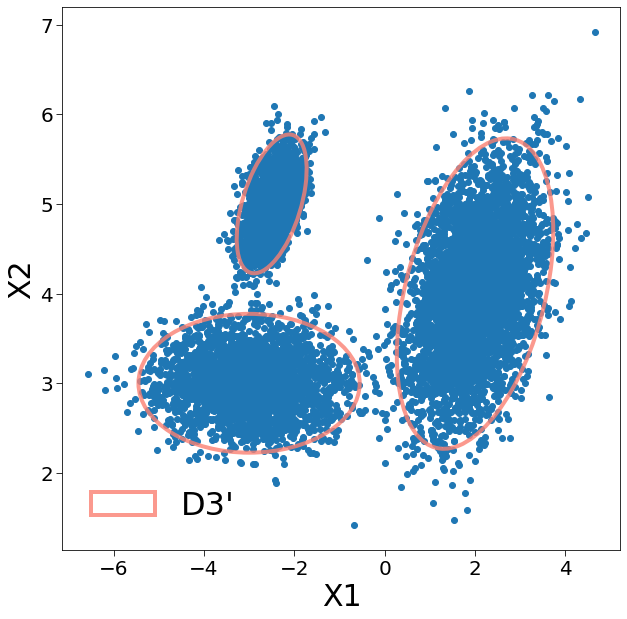

In [2]:
analytic = D3p.estimate_MI_MC(MC_samples=1e5)
print(analytic)
plot_contours(D3p, ls='-', label="D3'")

### Test on 500 trials

In [7]:
N = 10000
random_states = 500

# parameters to play with
n_inits = 10
n_folds = 5
init_type = 'random_sklearn'
MC_samples = 1e5
tol = 1e-6
reg_covar = 1e-15
all_MI_estimates = np.zeros((random_states))

for r_ in range(random_states):
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=r_+50000)
    X = gmm_true.sample(N)[0]
    
    # fix number of components to true model
    # create empty arrays for multiple initialisations
    val_scores_seeds = np.zeros(n_inits)
    train_scores_seeds = np.zeros(n_inits)
    
    # these are one for each init and each fold; we'll average over these at the end of the CV
    validation_scores = np.zeros((n_inits, n_folds))
    training_scores = np.zeros((n_inits, n_folds))
    
    # prepare the folds; note the splitting will be the same for all initialisations
    # the random seed is fixed here, but results should be independent of the exact split
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # also create emoty arrays for final GMM parameters
    all_ws = np.zeros((n_inits, n_folds, n_components))
    all_ms = np.zeros((n_inits, n_folds, n_components, 2))
    all_cs = np.zeros((n_inits, n_folds, n_components, 2, 2))    
    all_ps = np.zeros((n_inits, n_folds, n_components, 2, 2))    

    # loop over the different initialisations
    for r in range(n_inits):

        # initialise with different seed r
        w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)

        # perform k-fold CV
        for k_idx, (train_indices, valid_indices) in enumerate(kf.split(X)):
            X_training = X[train_indices]
            X_validation = X[valid_indices]

            fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=r, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_training)

            # we take the mean logL per sample, since folds might have slightly different sizes
            val_score = fitted_gmm.score_samples(X_validation).mean()
            # this won't be used, but we store it for debugging purposes
            train_score = fitted_gmm.score_samples(X_training).mean()

            # save current scores, as well as parameters
            validation_scores[r, k_idx] = np.copy(val_score)
            training_scores[r, k_idx] = np.copy(train_score)
            all_ws[r, k_idx] = np.copy(fitted_gmm.weights_)
            all_ms[r, k_idx] = np.copy(fitted_gmm.means_)
            all_cs[r, k_idx] = np.copy(fitted_gmm.covariances_)
            all_ps[r, k_idx] = np.copy(fitted_gmm.precisions_)


        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores[r])
        train_scores_seeds[r] = np.mean(training_scores[r])


    # select seed with highest val score across the different inits
    best_seed = np.argmax(val_scores_seeds)
    best_val_score = np.max(val_scores_seeds)
    best_train_score = np.max(train_scores_seeds)
    # within the best fold, select the model with the highest validation logL
    best_fold_in_init = np.argmax(validation_scores[best_seed])

    # select the final parameters as starting point for the final fit
    w_init, m_init, c_init, p_init = all_ws[best_seed, best_fold_in_init], all_ms[best_seed, best_fold_in_init], all_cs[best_seed, best_fold_in_init], all_ps[best_seed, best_fold_in_init]
    # alternatively, we also allow to start from the best initialisation
    #w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=n_components, init_type=init_type)

    # fit the final model on all X using the GMM parameters selected above
    gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
            tol=tol, max_iter=10000, 
            random_state=best_seed, weights_init=w_init, 
            means_init=m_init, precisions_init=p_init).fit(X)

    # now get a single MI estimate with MC integration (last step)
    single_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)

    # print for debugging purposes
    print(r_, single_MI_estimate) 

    all_MI_estimates[r_] = single_MI_estimate

    # save, if needed
    #np.save('./D3p_bias_MI_test.npy', all_MI_estimates)

0 0.384323292386762
1 0.38300567948561826
2 0.3897845812436036
3 0.3845155770339642
4 0.38049278883485727
5 0.3935668324035861
6 0.388403080767432
7 0.39241577730691185
8 0.39377089281949956
9 0.3808277325971193
10 0.3830345373145952
11 0.39155919706845654
12 0.3910720718741627
13 0.38743497868512533
14 0.3929217013644472
15 0.39846710728277446
16 0.3912987356145946
17 0.3775909229613272
18 0.38570179173025
19 0.39732748512275984
20 0.4009141328679034
21 0.39203113290693065
22 0.3863066568982816
23 0.38873935601060416
24 0.3982616525464328
25 0.3970075209507945
26 0.3939030153631926
27 0.387430841820723
28 0.39200978575823225
29 0.3954682599920815
30 0.39627336047360623
31 0.38297894446059183
32 0.388748353968406
33 0.39290082347253874
34 0.3877949642368286
35 0.3990573020620388
36 0.40075864704436004
37 0.38993436437256823
38 0.38375484883468447
39 0.3979588857182537
40 0.39539634651661276
41 0.3981880911533682
42 0.3922076644279082
43 0.3941947247372182
44 0.38466995426156425
45 0.39

355 0.3956823514065699
356 0.38486793770369376
357 0.38342495944075183
358 0.3962285051785996
359 0.3987317330200368
360 0.4007534593021203
361 0.39702239933678035
362 0.40486082434298476
363 0.3903916907322687
364 0.40253646356179174
365 0.3833244623805776
366 0.3932116321554398
367 0.38913702885584783
368 0.386824496214619
369 0.395157819679655
370 0.4041064942201725
371 0.40062636343175845
372 0.3816627226609754
373 0.384172353326611
374 0.38295060313526197
375 0.3889440636196461
376 0.3911479968720938
377 0.39164783676940657
378 0.3785957810684576
379 0.3885067798413002
380 0.39389024505891707
381 0.38938639789746277
382 0.38090865705397214
383 0.39413415458126977
384 0.3929059440746718
385 0.39993366082944515
386 0.40365305145815883
387 0.39162379209223663
388 0.39563559490753547
389 0.3835952366294634
390 0.38332562763964145
391 0.391907350787793
392 0.39129520075339047
393 0.3844125572112265
394 0.38206741390538485
395 0.3937034423809781
396 0.3866020429661692
397 0.391804221258

In [ ]:
58 0.4017015797715695 0.3985687722195337


### Evaluate MI bias

In [ ]:
# load in case you saved it
#all_MI_estimates = np.load('./D3p_bias_MI_test.npy')

# shift to 0
all_MI_estimates = all_MI_estimates - analytic

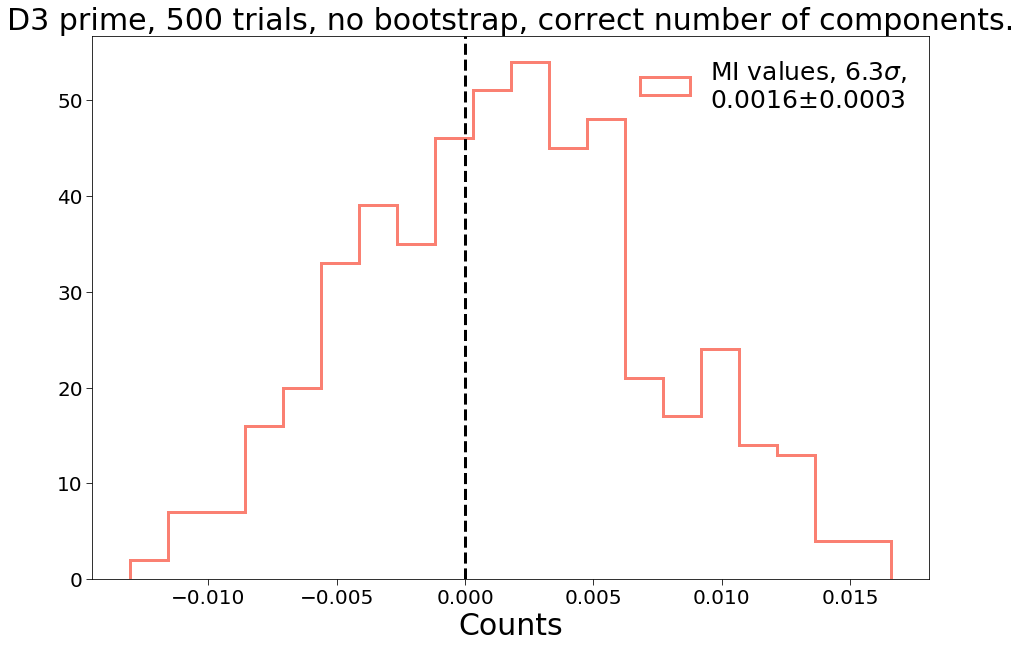

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))

bins=20
alpha=1
legendsize=25

# calculate significance
sigmas = np.sqrt(random_states)*np.mean(all_MI_estimates) / np.std(all_MI_estimates)
# and plot
ax1.hist(all_MI_estimates.flatten(), alpha=alpha, bins=bins, 
         label=f'MI values, {sigmas:.1f}$\sigma$,\n{np.mean(all_MI_estimates):.4f}$\pm${np.std(all_MI_estimates)/np.sqrt(random_states):.4f}', 
         color='salmon', histtype='step', lw=3)


ax1.axvline(0, ls='--', lw=3, c='k')
ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax1.legend(fontsize=legendsize, frameon=False)
ax1.set_xlabel('MI [nats]', fontsize=30)
ax1.set_xlabel('Counts', fontsize=30)

# change title accordingly
ax1.set_title(f'D3 prime, {random_states} trials, no bootstrap, correct number of components.', fontsize=30);